In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import os

import matplotlib.pyplot as plt
import PIL

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride= stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential() #stride = 1   (identity mapping 이라면)

    if stride != 1: # stride 가 1이 아니라면 x와 F(x)의 이미지 크기가 다르므로 맞춰서 변경해주는 conv layer를 추가해준다.
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(out_channels)
      )
    
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x))) 
    out = self.bn2(self.conv2(out))  #2개의 신경망을 쌓는다. 
    out += self.shortcut(x) #학습 난이도를 쉽게하기 위해 기존의 x를 더해준다
    out = F.relu(out)

    return out

In [4]:
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes = 10): #block > BasicBlock 객체로 받음
    super(ResNet, self).__init__()

    self.in_channels = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1, bias = False) #크기는 그대로, feature만 증가가
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layers(block, 64, num_blocks[0], stride = 1)
    self.layer2 = self._make_layers(block, 128, num_blocks[1], stride = 2)
    self.layer3 = self._make_layers(block, 256, num_blocks[2], stride = 2)
    self.layer4 = self._make_layers(block, 512, num_blocks[3], stride = 2)
    self.linear = nn.Linear(512, num_classes)

  def _make_layers(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1) #첫번째 레이어에서만 크기변화, 나머지는 identity mapping
    layers = []

    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)
  
  def forward(self, x):

    out = F.relu(self.bn1(self.conv1(x)))

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)

    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    
    return out

In [32]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = '/content/drive/MyDrive', train= True, download = True, transform = train_transforms)
valid_dataset = torchvision.datasets.CIFAR10(root = '/content/drive/MyDrive', train = False, download = False, transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers =2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 100, shuffle = False, num_workers =2)

Files already downloaded and verified


In [13]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
img, target = next(iter(train_loader))
img.size()
img_list = img[:10]
target = target[:10]

In [48]:
img.shape

torch.Size([128, 3, 32, 32])

In [12]:
target

tensor([1, 5, 3, 3, 8, 7, 2, 7, 1, 0])

In [19]:
output = net(img)

In [21]:
output.shape

torch.Size([128, 10])

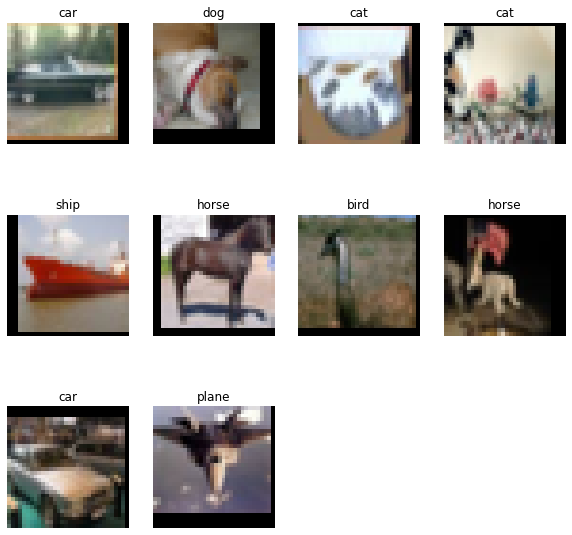

In [15]:


plt.figure(figsize = (10, 10))
for i in range(1, 10+1):
  plt.subplot(3, 4, i)
  plt.imshow(img_list[i-1].permute(1,2,0))
  plt.title(classes[target[i-1]])
  plt.axis('off')

In [44]:
net = ResNet(BasicBlock, [2,2,2,2], num_classes = 10)
net = net.to(device)
net = torch.nn.DataParallel(net) #모델을 병렬처리해 여러개의 gpu로 빠르게 학습할 수 있도록 한다

learning_rate = 0.1
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.0002)

In [45]:
net

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [47]:
epochs = 20
best_acc = 0
path = '/content/drive/MyDrive/'

for epoch in range(epochs):
  net.train()

  train_loss = 0.0
  valid_loss = 0.0
  correct = 0
  total = 0 
  for inputs, targets in train_loader:

    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    _, predict = outputs.max(1)  # 배치크기의 label값 리턴
    correct += predict.eq(targets).sum().item()
    total += targets.size(0)


  print('EPOCH : ', epoch+1, 'Train Loss : {:.2f}'.format(train_loss/len(train_loader)) ,'Accuracy : {:.2f}'.format(correct / total))

  correct = 0
  total = 0

  with torch.no_grad():
    net.eval()

    for inputs, targets in valid_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      
      outputs = net(inputs)

      loss = criterion(outputs, targets)
      valid_loss += loss.item()

      _, predict = outputs.max(1)
      correct += predict.eq(targets).sum().item()
      total += targets.size(0)

      valid_acc = correct / total

    print('EPOCH : ', epoch+1,'Valid Loss :{:.2f}'.format(valid_loss /len(valid_loader)), 'Valid accuracy :{:.2f}'.format(valid_acc))
    
    if (valid_acc > best_acc):
      best_acc = valid_acc
      torch.save(net, path+ 'resnet.h5')
      print("New model saved")

EPOCH :  1 Train Loss : 1.55 Accuracy : 0.42
EPOCH :  1 Valid Loss :1.54 Valid accuracy :0.44
New model saved
EPOCH :  2 Train Loss : 1.36 Accuracy : 0.50
EPOCH :  2 Valid Loss :1.38 Valid accuracy :0.51
New model saved
EPOCH :  3 Train Loss : 1.17 Accuracy : 0.58
EPOCH :  3 Valid Loss :1.24 Valid accuracy :0.56
New model saved
EPOCH :  4 Train Loss : 1.00 Accuracy : 0.64
EPOCH :  4 Valid Loss :2.38 Valid accuracy :0.36
EPOCH :  5 Train Loss : 0.87 Accuracy : 0.69
EPOCH :  5 Valid Loss :1.59 Valid accuracy :0.50
EPOCH :  6 Train Loss : 0.77 Accuracy : 0.73
EPOCH :  6 Valid Loss :1.19 Valid accuracy :0.62
New model saved
EPOCH :  7 Train Loss : 0.69 Accuracy : 0.76
EPOCH :  7 Valid Loss :0.74 Valid accuracy :0.74
New model saved
EPOCH :  8 Train Loss : 0.62 Accuracy : 0.79
EPOCH :  8 Valid Loss :0.71 Valid accuracy :0.76
New model saved
EPOCH :  9 Train Loss : 0.55 Accuracy : 0.81
EPOCH :  9 Valid Loss :0.68 Valid accuracy :0.77
New model saved
EPOCH :  10 Train Loss : 0.50 Accuracy : 0